In [219]:
import mdtraj as md
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('colorblind')

## Tests

1.  Velocity-velocity and position-position autocorrelation functions for two active site atoms
2.  Radial distribution (g(r)) functions for same active site atoms
3.  Import water g(r) from VMD as it deals with PBC nicely


## Select atoms

In [184]:
top = md.load_prmtop('../common/2agy_final_min.prmtop')
table, bond = top.to_dataframe()

In [185]:
print(table.loc[(table['resName']=='TTW') & (table['name']=='CI2'),:])
print(table.loc[(table['resSeq'] == 418) & (table['name']=='CG'),:])
atom_indices  = [6100, 6404]

      serial name element  resSeq resName  chainID segmentID
6100    None  CI2       C     399     TTW        0          
13310   None  CI2       C     872     TTW        0          
     serial name element  resSeq resName  chainID segmentID
6404   None   CG       C     418     ASP        0          


In [204]:
masses = {'C': 12, 'N': 14, 'H': 1, 'O':16}
sel = table.loc[(table['resSeq']==399) | (table['resSeq']==418), :]
sel_ind = list(sel.index)
print(sel_ind)

[6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408]


## Import trajectories

In [262]:
cases_fn = {'cut12': 'cut12.mdcrd',
            'cut10': 'cut10.mdcrd',
            'cut11': 'cut11.mdcrd', 
           'cut13': 'cut13.mdcrd'}
#             'hmrcut10': 'hmrcut10.mdcrd',
#             'hmrcut12': 'hmrcut12.mdcrd'}
cases_traj = {}
for k, v in cases_fn.items():
    cases_traj[k] = md.load_netcdf(filename=v, top=top, atom_indices=sel_ind)


In [263]:
positions = {}
velocities = {}
for k, v in cases_traj.items():
#     r = v.xyz[:,0,:] - v.xyz[:,1,:]
    r = md.compute_center_of_mass(v)
    print(k, r.shape)
    positions[k] = r

 

cut10 (5000, 3)
cut12 (5000, 3)
cut11 (5000, 3)
cut13 (5000, 3)


## Calculate ACFs

In [264]:
def acf(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
#     print((np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)])-r).sum())
#     assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [265]:
def plot_acf(series, xlim=None):
    for k, v in series.items():
        ct = np.array([acf(v[:,i]) for i in range(3)]).mean(axis=0)
        dt = cases_traj[k].timestep
        print(k, dt)
        t = np.arange(len(ct))*dt
        plt.plot(t, ct, label='{}'.format(k))

    plt.legend()
    plt.xlabel('Time (ps)')
    plt.ylabel('ACF')
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylim((0,1))

cut10 0.0999756
cut12 0.0999756
cut13 0.0999756
cut11 0.0999756


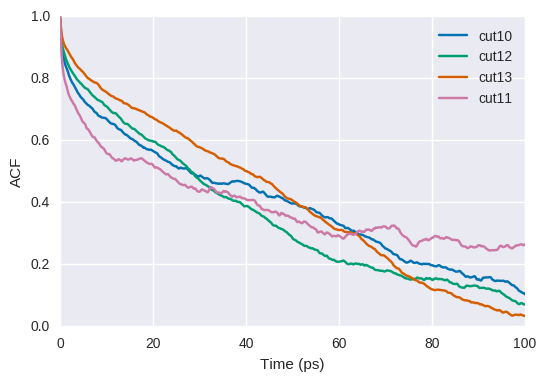

In [266]:
plot_acf(positions, xlim=(0,100))